### 1. Using 04_hotel_cancellation.csv, estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Treat all the other columns as the covariates. 

In [1]:
#!pip install causalinference
#!pip install python-dotenv
#!conda install -c r r-glmnet

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

from causalinference import CausalModel
from sklearn import neighbors, datasets
from sklearn.linear_model import LassoCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [3]:
# Overview of the dataset
hotel = pd.read_csv("04_hotel_cancellation.csv")
hotel.head()

,Unnamed: 0,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,days_in_waiting_list,different_room_assigned,is_canceled
0,3,13,2015,27,1,0,False,False
1,4,14,2015,27,1,0,False,False
2,5,14,2015,27,1,0,False,False
3,7,9,2015,27,1,0,False,False
4,8,85,2015,27,1,0,False,True


In [25]:
# Create the treatment indicator
d = hotel[['different_room_assigned']]
d = d.replace({True:1, False:0})

# Create the observed outcome
y = hotel[['is_canceled']]
y = y.replace({True:1, False:0})

# Create the covariates matrix
X = hotel.iloc[:,1:6]

In [6]:
# Create the causal model
causal = CausalModel(D = d.values, Y = y.values, X = X.values)
print(causal.summary_stats)


Summary Statistics

                     Controls (N_c=91673)       Treated (N_t=11221)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.432        0.495        0.051        0.220       -0.381

                     Controls (N_c=91673)       Treated (N_t=11221)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0      116.468      109.178       73.114       85.262       -0.443
             X1     2016.182        0.703     2015.949        0.695       -0.334
             X2       27.249       13.100       28.076       14.651        0.060
             X3       15.804        8.804       15.642        8.714       -0.019
             X4        2.644       18.955        2.422       17.457       -0.012



In [7]:
# includes the treatment variable and the covariates as the model predictors
causal.est_via_ols(adj=1)
print('adj=1', causal.estimates)

adj=1 
Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.337      0.003   -118.276      0.000     -0.343     -0.332



C:\Users\59699\anaconda3\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Observations: 
1. The estimated average treatment effect is -0.337
2. The p-value of the estimation is extremely small and the 95% confidence interval doesn't include zero, we can conclude that the whether be assigned a different room or not affects the likelihood for a customer to cancel a room
3. The negative estimated average treatment effect indicates that when a different room is assigned to a customer, the chance of the customer to cancel the reservation is estimated to reduce, controlling other covariates.

In [37]:
# Use logit model to estimate the treatment effect
x = pd.concat([X,d], axis = 1)

model = sm.Logit(y,x)
result = model.fit()
print(result.params)

Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 7
lead_time                    0.005202
arrival_date_year           -0.000375
arrival_date_week_number    -0.004168
arrival_date_day_of_month   -0.001143
days_in_waiting_list         0.001325
different_room_assigned     -2.518556
dtype: float64


Observations:<br>
Logit model also gives a negative treatment effect: -2.52. It validated the result we got from the causal model that assigning a different room to a customer leads to lower chance of cancel the book, controling other covariates.

In [44]:
'''
Notes for CausalModel:
# only includes the treatment variable as the model predictors
causal.est_via_ols(adj=0)
print('adj=0', causal.estimates)

# includes the treatment variable, the covariates, and the interactions between the treatment variable and the covariates as model predictors
causal.est_via_ols(adj=2)
print('adj=2', causal.estimates)
'''

"\nNotes for CausalModel:\n# only includes the treatment variable as the model predictors\ncausal.est_via_ols(adj=0)\nprint('adj=0', causal.estimates)\n\n# includes the treatment variable, the covariates, and the interactions between the treatment variable and the covariates as model predictors\ncausal.est_via_ols(adj=2)\nprint('adj=2', causal.estimates)\n"

### 2. For 04_hotel_cancellation.csv, use double lasso regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’

In [56]:
# Estimate d_hat
logit_1 = sm.Logit(d, X).fit()
d_hat = logit_1.predict(X)

# Combine d_hat and the rest variables
d_hat = pd.DataFrame(data = {"d_hat": d_hat[:]})
x_new = pd.concat([x,d_hat], axis = 1)

# The second stage logistic regression
logit_2 = sm.Logit(y, x_new).fit()
print(logit_2.params)

Optimization terminated successfully.
         Current function value: 0.334283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596827
         Iterations 7
lead_time                     0.000658
arrival_date_year             0.000395
arrival_date_week_number      0.005383
arrival_date_day_of_month    -0.004647
days_in_waiting_list          0.004968
different_room_assigned      -2.504256
d_hat                       -11.692611
dtype: float64


### 3. Use bootstrap to estimate the standard error of the treatment effects measured in (2).

In [82]:
# Define the number of resampling
n = 1000

# Initialize the vector to store the treatment effects
treatment_effects = np.zeros(1000)

# Bootstrap
i = 0
while i < n:
    resample_index = np.random.choice(hotel.index, size = hotel.index.size, replace = True)
    resample = hotel.iloc[resample_index]
    X_resample = X.iloc[resample_index]
    x_resample = x.iloc[resample_index]
    y_resample = y.iloc[resample_index]
    
    model1 = sm.Logit(y_resample, X_resample).fit()
    d_hat = np.array(model1.predict(X_resample)).reshape(X_resample.shape[0],1)
    x_new = np.hstack((x_resample,d_hat))
    
    model2 = sm.Logit(y_resample, x_new).fit()
    
    treatment_effects[i] = model2.params[-2]
    
    i += 1

Optimization terminated successfully.
         Current function value: 0.628765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598253
  

In [83]:
# Calculate the standard errors of treatment effects
treatment_effects_se = treatment_effects.std(axis=0) / math.sqrt(n)
treatment_effects_se

0.001434772753168267

### 4. Use 04_drinking.csv to play around with Regression Discontinuity Design

#### a) Keeping 21 as the threshold for age, explore the data with an RDD by writing very simple code to determine if alcohol increases the chances of death by accident, suicide and/or others

In [2]:
# Overview of the dataset
drinking = pd.read_csv("drinking.csv")
drinking.head()

,age,others,accident,suicide
0,19.068493,92.825401,35.829327,11.203714
1,19.150684,95.100739,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315069,88.427757,32.278957,11.275010
4,19.397261,88.704941,32.650967,10.984314


In [79]:
# Split the data into age ranging from 20 to 21 and from 21 to 22
below = drinking[(drinking["age"] >= 20) & (drinking["age"] < 21)]
above = drinking[(drinking["age"] >= 21) & (drinking["age"] < 22)]

In [108]:
# Calculate the expected value of observations lying closely to the threshold
acc_bl = below["accident"].mean()
acc_ab = above["accident"].mean()

sui_bl = below["suicide"].mean()
sui_ab = above["suicide"].mean()

oth_bl = below["others"].mean()
oth_ab = above["others"].mean()

RDD = pd.DataFrame({"Age from 20 to 21": [acc_bl, sui_bl, oth_bl],
                   "Age from 21 to 22": [acc_ab, sui_ab, oth_ab],
                   "Death by": ["Accident", "Suicide", "Others"]}).set_index("Death by")
RDD

,Age from 20 to 21,Age from 21 to 22
Death by,,
Accident,31.296563,32.635049
Suicide,11.642920,13.361998
Others,93.318850,99.860510


From the RDD result table above, the expected chances of death by accident, suicide, and others all increase as one's age goes across 21, which is the legal age for drinking. It implies that legalizing drinking may cause increase in chances of death by accident, suicide, and others. Therefore, we should not reduce the legal age for drinking from 21 because of the negative effect of alcohol and that younger people may be more influenced by the bad effect.

#### b) Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

// Disable scrolling to show the plot without a scrollbar

<IPython.core.display.Javascript object>

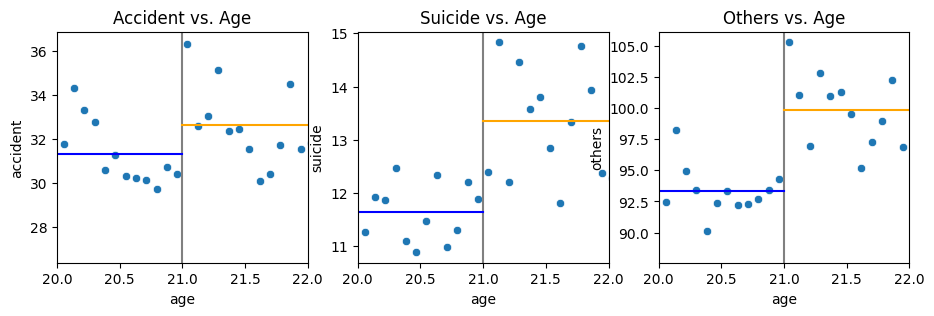

In [153]:
def plot_RDD(below, above, bandwidth):
    '''Draw the relationship plots between age and (accident, suicide, and others)'''
    # Specify the plot size
    plt.figure(figsize=(11,3))

    # accident vs age
    plt.subplot(131)
    ava = sns.scatterplot(x = "age", y = "accident", data = drinking)
    ava.axvline(21, color = "grey")
    ava.set(title = "Accident vs. Age")
    ava.axhline(y=below["accident"].mean(), xmin=0, xmax=0.5, color="blue")
    ava.axhline(y=above["accident"].mean(), xmin=0.5, xmax=1, color="orange")
    ava.set(xlim = (21-bandwidth, 21+bandwidth))

    # suicide vs age
    plt.subplot(132)
    sva = sns.scatterplot(x = "age", y = "suicide", data = drinking)
    sva.set(title = "Suicide vs. Age")
    sva.axvline(21, color = "grey")
    sva.axhline(below["suicide"].mean(), xmin=0, xmax=0.5, color="blue")
    sva.axhline(above["suicide"].mean(), xmin=0.5, xmax=1, color="orange")
    sva.set(xlim = (21-bandwidth, 21+bandwidth))

    # others vs age
    plt.subplot(133)
    ova = sns.scatterplot(x = "age", y = "others", data = drinking)
    ova.axvline(21, color = "grey")
    ova.set(title = "Others vs. Age")
    ova.axhline(below["others"].mean(), xmin=0, xmax=0.5, color="blue")
    ova.axhline(above["others"].mean(), xmin=0.5, xmax=1, color="orange")
    ova.set(xlim = (21-bandwidth, 21+bandwidth))

plot_RDD(below, above, 1)

In [157]:
def plot_RDD_lm(below, above, bandwidth):
    '''Draw the relationship plots between age and (accident, suicide, and others)'''
    # Specify the plot size
    plt.figure(figsize=(11,3))

    # accident vs age
    plt.subplot(131)
    ava = sns.scatterplot(x = "age", y = "accident", data = drinking)
    ava.axvline(21, color = "grey")
    ava.set(title = "Accident vs. Age")
    sns.regplot(x="age", y="accident", data=below)
    sns.regplot(x="age", y="accident", data=above)
    ava.set(xlim = (21-bandwidth, 21+bandwidth))

    # suicide vs age
    plt.subplot(132)
    sva = sns.scatterplot(x = "age", y = "suicide", data = drinking)
    sva.set(title = "Suicide vs. Age")
    sva.axvline(21, color = "grey")
    sns.regplot(x="age", y="suicide", data=below)
    sns.regplot(x="age", y="suicide", data=above)
    sva.set(xlim = (21-bandwidth, 21+bandwidth))

    # others vs age
    plt.subplot(133)
    ova = sns.scatterplot(x = "age", y = "others", data = drinking)
    ova.axvline(21, color = "grey")
    ova.set(title = "Others vs. Age")
    sns.regplot(x="age", y="others", data=below)
    sns.regplot(x="age", y="others", data=above)
    ova.set(xlim = (21-bandwidth, 21+bandwidth))

#plot_RDD_lm(below, above, 1)

#### c) What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth?

1. Choosing a smaller bandwidth is theoretically more accurate. However, in this case, one thing to note is that not everyone just begins to drink from exactly their 21st birthday. Some people may drink slightly before 21st birthday, which is illegal obviously but it does happen, and some people may not drink right after their 21st birthday (they may try alcohol after 22 or later). Therefore, in this scenario, choosing a tight investigation width may amplify the contamination among data. Besides, since the amount of observations is limited, the result of a smaller bandwidth with fewer observations may not be reliable.
2. Choosing a larger bandwidth (the max bandwidth) would let confounders into the play. For example, the rate of death by accident, suicide, or others may inherently decrease or increase because of people's mental growth or even physical state. So drinking may not be the only reason that accounts for the difference between expected death rates. It may even flip the estimated causal effect and we should avoid this.

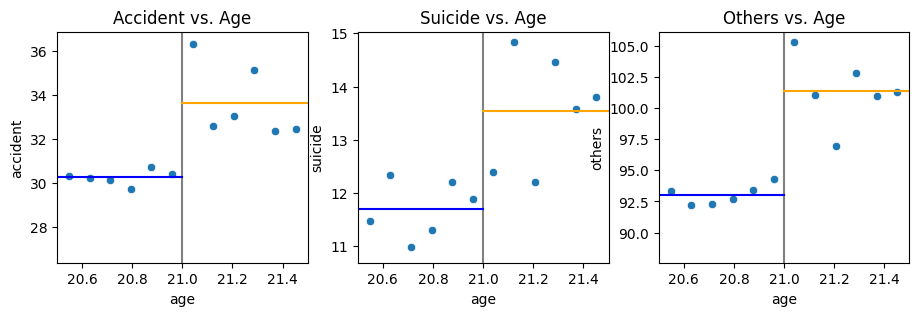

In [154]:
# Choose a smaller bandwidth (0.5 year)
below_s = drinking[(drinking["age"] >= 20.5) & (drinking["age"] < 21)]
above_s = drinking[(drinking["age"] >= 21) & (drinking["age"] < 21.5)]

# Plot the new relationships
plot_RDD(below_s, above_s, 0.5)

A smaller bandwidth leads to the same results with even larger differences in death rate.

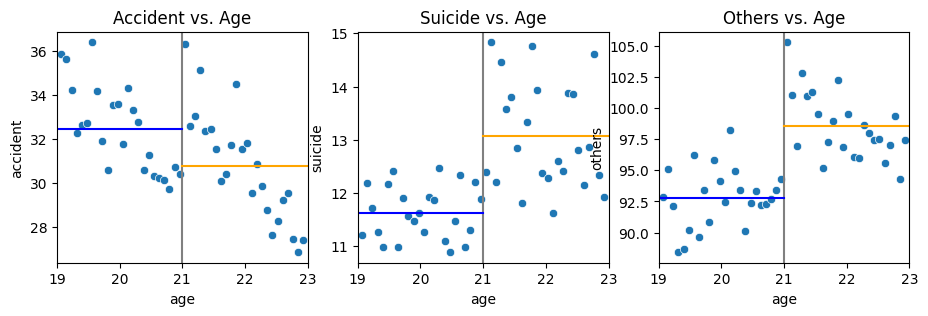

In [155]:
# Choose the max bandwidth (2 year)
below_m = drinking[(drinking["age"] >= 19) & (drinking["age"] < 21)]
above_m = drinking[(drinking["age"] >= 21) & (drinking["age"] < 23)]

# Plot the new relationships
plot_RDD(below_m, above_m, 2)

The max bandwidth leads to a flipped result - the chance of death by accident appears higher before 21 than after. It may be because younger people are less capable of protecting themselves and their body may not be as strong on average, and it is apparently not because they don't drink.

### 5. Use the 05_iris.csv dataset for playing around with K-nearest neighbors. Find out the optimal value of k

In [3]:
# Overview of the data set
iris = pd.read_csv("iris.csv")
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [9]:
# Determine the explanatory variables and the response variable
x = iris.iloc[:,:-1]
y = iris.iloc[:,-1]

pandas.core.series.Series

In [11]:
# Split the data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=117)

In [70]:
# The number of neighbors: 1,3,5,7
klist = ['k=1','k=3','k=5','k=7']

# Initialize lists and dataframes for storing information
y_preds = pd.DataFrame(columns=klist)
accs = pd.DataFrame(columns=["Accuracy"])

ind = 0
for i in range(1,8,2):
    model = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_preds.iloc[:,ind] = y_pred
    acc = metrics.accuracy_score(y_test, y_pred)
    accs.loc[len(accs.index)] = acc
    
    ind += 1

accs.index = klist

In [67]:
accs

,Accuracy
k=1,0.933333
k=3,0.955556
k=5,0.977778
k=7,0.933333


Based on the result table above, the accuracy of the model is the highest when k = 5. So 5 is the optimal choice of k among 1, 3, 5, 7 in this situation.

Euclidean distance is utilized by the library I used to perform K-Nearest Neighbor.  
For four dimensions, which is the case we are facing:  
${\displaystyle d(p,q)={\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+(p_{3}-q_{3})^{2}+(p_{4}-q_{4})^{2}}}.}$

We here use Euclidean distance because:  
1. Euclidean distance is simple to calculate and easy to use  
2. Euclidean distance is commonly used in many applications  
3. The features we used are all numeric and of the same unit and scale. In this case, the magnitude of the Euclidean distance of two points would be proportional to the difference of their feature values. So Euclidean distance is favored in this solving problem  